In [1]:
import pandas as pd
import numpy as np

# Plotting Packages
import matplotlib.pyplot as plt
import seaborn as sns

import matplotlib as mpl
mpl.rcParams['figure.dpi'] = 150
savefig_options = dict(format="png", dpi=150, bbox_inches="tight")

# Computation packages
from scipy.spatial.distance import euclidean
from fastdtw import fastdtw

In [2]:
def compute_distance_matrix(x, y) -> np.array:
    """Calculate distance matrix
    This method calcualtes the pairwise Euclidean distance between two sequences.
    The sequences can have different lengths.
    """
    dist = np.zeros((len(y), len(x)))
    for i in range(len(y)):
        for j in range(len(x)):
            dist[i,j] = np.abs(x[j]-y[i])
    return dist

In [3]:
def compute_accumulated_cost_matrix(x, y) -> np.array:
    """Compute accumulated cost matrix for warp path using Euclidean distance
    """
    distances = compute_distance_matrix(x, y)

    # Initialization
    cost = np.zeros((len(y), len(x)))
    cost[0,0] = distances[0,0]
    
    for i in range(1, len(y)):
        cost[i, 0] = distances[i, 0] + cost[i-1, 0]  
        
    for j in range(1, len(x)):
        cost[0, j] = distances[0, j] + cost[0, j-1]  

    # Accumulated warp path cost
    for i in range(1, len(y)):
        for j in range(1, len(x)):
            cost[i, j] = min(
                cost[i-1, j],    # insertion
                cost[i, j-1],    # deletion
                cost[i-1, j-1]   # match
            ) + distances[i, j] 
            
    return cost

In [4]:
df=pd.read_csv('../clean_data/gap_list.csv')

In [5]:
alabama=df['Gaps'][0]
import ast
alabama_list = ast.literal_eval(alabama)
alaska_list=ast.literal_eval(df['Gaps'][1])

In [6]:
alabama_list

[-11.0, -15.0, -15.0, -10.0, -12.0, -9.0, -9.0, -12.0, -9.0, -17.0, -12.0]

In [7]:
#alabama_list=[-3, 0, 0, 1, 0, -1, 1, 0, 0, -1, 5]
#alaska_list =[3, 4, 1, 1, 2, 2, 1, 3, 0, 1, -4]

In [8]:
import numpy as np

# Define a custom distance function that ensures 1-D inputs
def custom_euclidean(u, v):
    u = np.array(u).ravel()
    v = np.array(v).ravel()
    return euclidean(u, v)

In [9]:
dtw_distance, warp_path = fastdtw(alabama_list,alaska_list, dist=custom_euclidean) 

In [10]:
cost_matrix = compute_accumulated_cost_matrix(alabama_list,alaska_list)

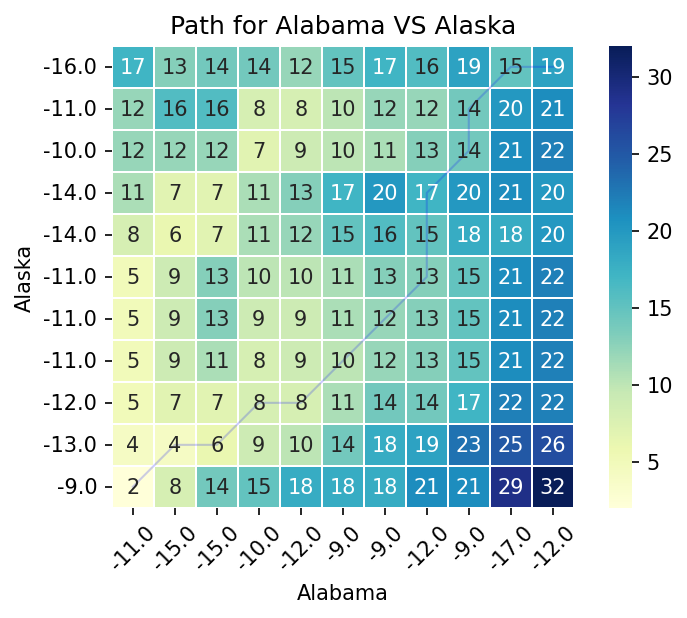

In [11]:
fig, ax = plt.subplots(figsize=(6, 4))
ax = sns.heatmap(cost_matrix, annot=True, square=True, linewidths=0.1, cmap="YlGnBu", ax=ax)
ax.invert_yaxis()

# Setting the x and y tick labels to alabama_list and alaska_list
ax.set_xticklabels(alabama_list, rotation=45)
ax.set_yticklabels(alaska_list, rotation=0)
ax.set_xlabel('Alabama')
ax.set_ylabel('Alaska')
ax.set_title('Path for Alabama VS Alaska')

# Adjusting ticks to align with the center of each cell
ax.set_xticks([i+0.5 for i in range(len(alabama_list))], minor=True)
ax.set_yticks([i+0.5 for i in range(len(alaska_list))], minor=True)
ax.grid(False)
ax.tick_params(which="minor", size=0)

# Get the warp path in x and y directions
path_x = [p[0] for p in warp_path]
path_y = [p[1] for p in warp_path]

# Align the path from the center of each cell
path_xx = [x+0.5 for x in path_x]
path_yy = [y+0.5 for y in path_y]

ax.plot(path_xx, path_yy, color='blue', linewidth=1, alpha=0.2)

In [12]:
print("DTW distance: ", dtw_distance)
print("Warp path: ", warp_path)

DTW distance:  25.0
Warp path:  [(0, 0), (1, 1), (2, 1), (3, 2), (4, 2), (5, 3), (6, 4), (7, 5), (7, 6), (7, 7), (8, 8), (8, 9), (9, 10), (10, 10)]


In [13]:
cost_matrix = compute_accumulated_cost_matrix(alabama_list,alaska_list)
print(np.flipud(cost_matrix)) 

[[17. 13. 14. 14. 12. 15. 17. 16. 19. 15. 19.]
 [12. 16. 16.  8.  8. 10. 12. 12. 14. 20. 21.]
 [12. 12. 12.  7.  9. 10. 11. 13. 14. 21. 22.]
 [11.  7.  7. 11. 13. 17. 20. 17. 20. 21. 20.]
 [ 8.  6.  7. 11. 12. 15. 16. 15. 18. 18. 20.]
 [ 5.  9. 13. 10. 10. 11. 13. 13. 15. 21. 22.]
 [ 5.  9. 13.  9.  9. 11. 12. 13. 15. 21. 22.]
 [ 5.  9. 11.  8.  9. 10. 12. 13. 15. 21. 22.]
 [ 5.  7.  7.  8.  8. 11. 14. 14. 17. 22. 22.]
 [ 4.  4.  6.  9. 10. 14. 18. 19. 23. 25. 26.]
 [ 2.  8. 14. 15. 18. 18. 18. 21. 21. 29. 32.]]


Text(0.5, 1.0, 'DTW Distance')

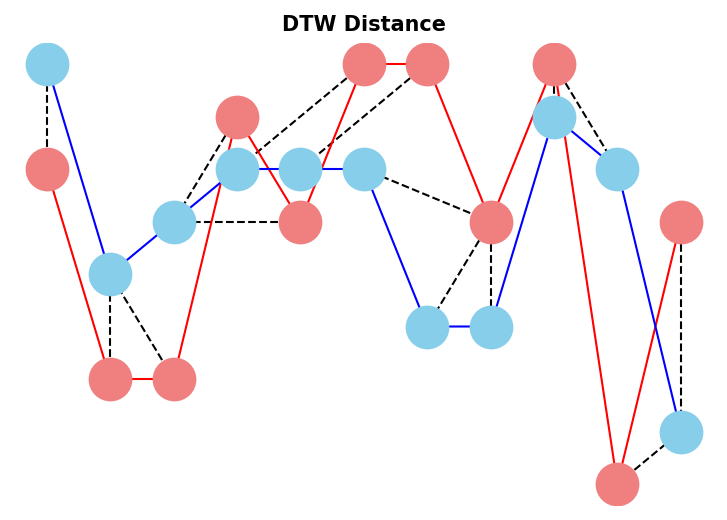

In [14]:
fig, ax = plt.subplots(figsize=(6, 4))

# Remove the border and axes ticks
fig.patch.set_visible(False)
ax.axis('off')

for [map_x, map_y] in warp_path:
    ax.plot([map_x, map_y], [alabama_list[map_x], alaska_list[map_y]], '--k', linewidth=1)

ax.plot(alabama_list, '-ro', label='Alabama', linewidth=1, markersize=20, markerfacecolor='lightcoral', markeredgecolor='lightcoral')
ax.plot(alaska_list, '-bo', label='Aalaska', linewidth=1, markersize=20, markerfacecolor='skyblue', markeredgecolor='skyblue')

ax.set_title("DTW Distance", fontsize=10, fontweight="bold")

In [15]:
from dtaidistance import dtw


In [16]:
distance=dtw.distance(alabama_list,alaska_list)

In [17]:
distance

6.244997998398398

In [18]:
from tslearn.metrics import dtw as ts_dtw
distance = ts_dtw(alabama_list,alaska_list)
print(f"DTW Distance: {distance}")

DTW Distance: 6.244997998398398


## Plot each states' distances

In [19]:
from ast import literal_eval
df['Gaps'] = df['Gaps'].apply(literal_eval)

In [20]:


# Redefine the number of states
num_states = len(df)

# Re-initialize the DTW distance matrix and compute the distances using the custom DTW implementation
dtw_matrix_custom = np.zeros((num_states, num_states))

for i in range(num_states):
    for j in range(i, num_states):
        if i == j:
            dtw_matrix_custom[i, j] = 0
        else:
            #distance = dtw.distance(df['Gaps'][i], df['Gaps'][j])
            distance, warp_path = fastdtw(df['Gaps'][i], df['Gaps'][j], dist=custom_euclidean) 
            dtw_matrix_custom[i, j] = dtw_matrix_custom[j, i] = distance

dtw_matrix_custom 

array([[ 0., 25., 29., ..., 20., 21., 23.],
       [25.,  0., 26., ..., 18., 18., 18.],
       [29., 26.,  0., ..., 29., 30., 19.],
       ...,
       [20., 18., 29., ...,  0., 20., 18.],
       [21., 18., 30., ..., 20.,  0., 31.],
       [23., 18., 19., ..., 18., 31.,  0.]])

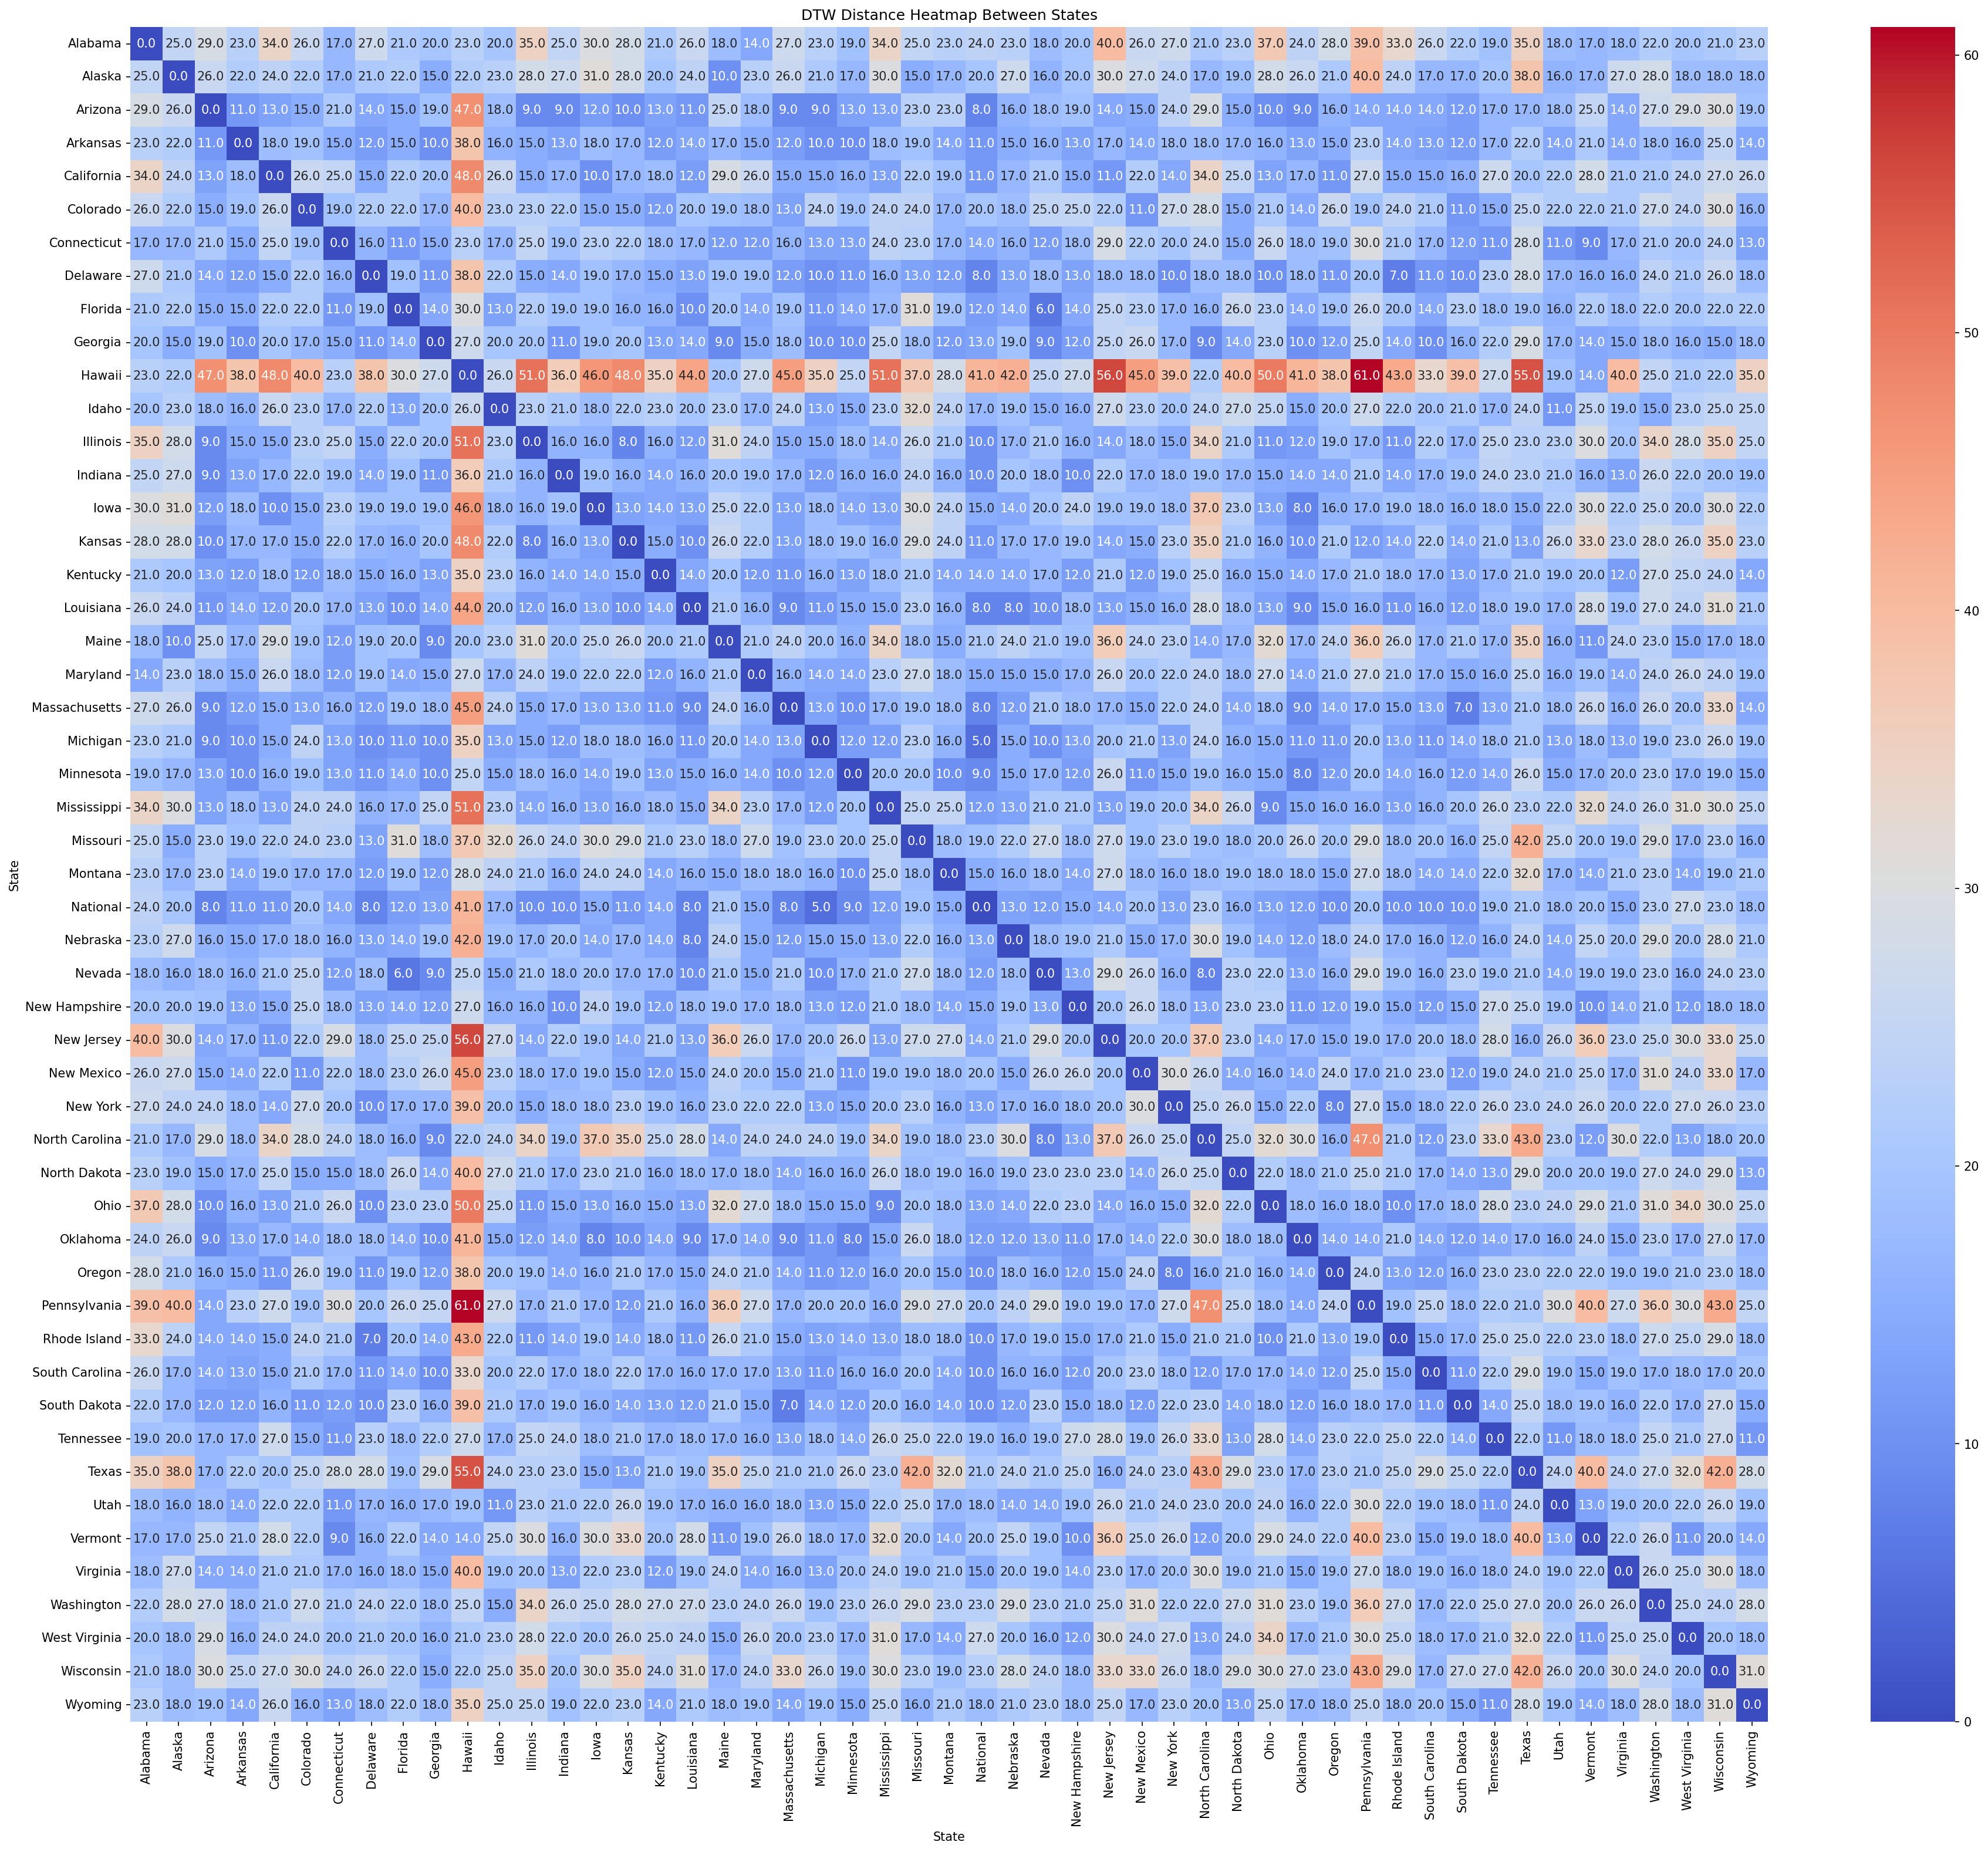

In [21]:


# Extract state names for axis labels
state_names = df['Jurisdiction'].values

# Create a heatmap of the DTW distance matrix
plt.figure(figsize=(30, 25))
sns.heatmap(dtw_matrix_custom, xticklabels=state_names, yticklabels=state_names, annot=True, fmt=".1f", cmap="coolwarm")
plt.title('DTW Distance Heatmap Between States')
plt.xlabel('State')
plt.ylabel('State')
plt.xticks(rotation=90)  # Rotate x-axis labels for better readability
plt.show()

In [22]:
# Find the minimum value in the DTW distance matrix excluding the diagonal
min_value = np.min(dtw_matrix_custom[np.nonzero(dtw_matrix_custom)])

# Find the row and column indices of the minimum value
min_index = np.where(dtw_matrix_custom == min_value)

# Extract the corresponding states
state_1 = state_names[min_index[0][0]]
state_2 = state_names[min_index[1][0]]

min_value, state_1, state_2

(5.0, 'Michigan', 'National')

In [23]:
# Filter out the 'National' jurisdiction from the DataFrame
data_filtered = df[df['Jurisdiction'] != 'National']

# Redefine the number of states without 'National'
num_states_filtered = len(data_filtered)

# Initialize an empty matrix to store the DTW distances for the filtered data
dtw_matrix_filtered = np.zeros((num_states_filtered, num_states_filtered))

# Compute the DTW distance for each pair of states using the custom DTW implementation and store in the matrix
for i in range(num_states_filtered):
    for j in range(i, num_states_filtered):
        if i == j:
            dtw_matrix_filtered[i, j] = 0
        else:
            distance, warp_path = fastdtw(df['Gaps'][i], df['Gaps'][j], dist=custom_euclidean) 
            dtw_matrix_filtered[i, j] = dtw_matrix_filtered[j, i] = distance

# Find the minimum value in the filtered DTW distance matrix excluding the diagonal
min_value_filtered = np.min(dtw_matrix_filtered[np.nonzero(dtw_matrix_filtered)])

# Find the row and column indices of the minimum value in the filtered matrix
min_index_filtered = np.where(dtw_matrix_filtered == min_value_filtered)

# Extract the corresponding states from the filtered data
state_names_filtered = data_filtered['Jurisdiction'].values
state_1_filtered = state_names_filtered[min_index_filtered[0][0]]
state_2_filtered = state_names_filtered[min_index_filtered[1][0]]

min_value_filtered, state_1_filtered, state_2_filtered


(5.0, 'Michigan', 'Nebraska')

In [24]:

# Step 1: Flatten the upper triangular part of the matrix, excluding the diagonal
upper_tri_indices = np.triu_indices_from(dtw_matrix_filtered, k=1)  # k=1 excludes the diagonal
distances_flattened = dtw_matrix_filtered[upper_tri_indices]

# Step 2: Sort the flattened array and get indices of the 10 smallest distances
sorted_indices = np.argsort(distances_flattened)[:10]

# Step 3: Use the sorted indices to find the corresponding state pairs
state_pairs = [(state_names_filtered[i], state_names_filtered[j]) for i, j in zip(upper_tri_indices[0][sorted_indices], upper_tri_indices[1][sorted_indices])]

# Step 4: Extract the 10 minimum distances
min_distances = distances_flattened[sorted_indices]

# Combine the state pairs with their corresponding distances
min_distance_pairs = [(state_pairs[i], min_distances[i]) for i in range(len(min_distances))]

min_distance_pairs

[(('Michigan', 'Nebraska'), 5.0),
 (('Florida', 'New Hampshire'), 6.0),
 (('Delaware', 'South Carolina'), 7.0),
 (('Massachusetts', 'Tennessee'), 7.0),
 (('Massachusetts', 'Nebraska'), 8.0),
 (('Minnesota', 'Oregon'), 8.0),
 (('Illinois', 'Kansas'), 8.0),
 (('North Carolina', 'Pennsylvania'), 8.0),
 (('Delaware', 'Nebraska'), 8.0),
 (('Arizona', 'Nebraska'), 8.0)]